Задание: Обучите модель линейной регрессии на найденных двумя способами трёх важных признаках и сравните полученные результаты. 



In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error 

from sklearn.preprocessing import OneHotEncoder

# Для графиков
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
%%capture
!wget https://www.dropbox.com/s/64ol9q9ssggz6f1/data_ford_price.xlsx

In [3]:
data = pd.read_excel('data_ford_price.xlsx') 

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7017 entries, 0 to 7016
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         7017 non-null   int64  
 1   year          7017 non-null   int64  
 2   condition     7017 non-null   int64  
 3   cylinders     7017 non-null   int64  
 4   odometer      7017 non-null   int64  
 5   title_status  7017 non-null   object 
 6   transmission  7017 non-null   object 
 7   drive         6626 non-null   object 
 8   size          5453 non-null   object 
 9   lat           7017 non-null   float64
 10  long          7017 non-null   float64
 11  weather       6837 non-null   float64
dtypes: float64(3), int64(5), object(4)
memory usage: 658.0+ KB


В выборке представлено 7 017 наблюдений и 12 характеристик для каждого из объектов.

<div align='center'><img src="https://lms.skillfactory.ru/assets/courseware/v1/c6ebd8733e171a77dab0dcf8988b3e31/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/dst3-ml6-2_4.png"></div>

Итого, нас есть:

* четыре признака типа object (обычно это строковые значения);
* пять признаков типа int64 (целочисленные значения);
* три признака типа float64 (числа с плавающей точкой).


#Предобработка: Заполнение пропусков в данных

In [5]:
#посмотрим на количество пропусков в данных
data.isnull().sum()

price              0
year               0
condition          0
cylinders          0
odometer           0
title_status       0
transmission       0
drive            391
size            1564
lat                0
long               0
weather          180
dtype: int64

Вывод: В признаках drive, size, weather есть пропуски.
Обработаем отсутствующие значения с учетом корреляционной связи данных признаков с остальными.

In [6]:
#отделим целевой признак от остальной выборки
y = data['price']
x = data.drop(columns='price')

In [7]:
#скопируем выборку для заполнения
data_for_filling = x.copy()
#в тестовую выборку возьмем все данные, где значение признака weather пропущено
test_data = data_for_filling[data_for_filling['weather'].isnull()]


In [8]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180 entries, 4 to 6973
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          180 non-null    int64  
 1   condition     180 non-null    int64  
 2   cylinders     180 non-null    int64  
 3   odometer      180 non-null    int64  
 4   title_status  180 non-null    object 
 5   transmission  180 non-null    object 
 6   drive         179 non-null    object 
 7   size          95 non-null     object 
 8   lat           180 non-null    float64
 9   long          180 non-null    float64
 10  weather       0 non-null      float64
dtypes: float64(3), int64(4), object(4)
memory usage: 16.9+ KB


In [9]:
#удалим из выборки для заполнения все строки с пропущенными значениями
data_for_filling.dropna(inplace=True)


In [10]:
data_for_filling.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5202 entries, 0 to 7016
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          5202 non-null   int64  
 1   condition     5202 non-null   int64  
 2   cylinders     5202 non-null   int64  
 3   odometer      5202 non-null   int64  
 4   title_status  5202 non-null   object 
 5   transmission  5202 non-null   object 
 6   drive         5202 non-null   object 
 7   size          5202 non-null   object 
 8   lat           5202 non-null   float64
 9   long          5202 non-null   float64
 10  weather       5202 non-null   float64
dtypes: float64(3), int64(4), object(4)
memory usage: 487.7+ KB


In [11]:
#в качестве признака для обучения выбираем искомый признак weather
y_train = data_for_filling['weather']
#в качестве выборки для обучения выбираем выборку для заполнения без признаков,
# содержавших пропущенные значения
X_train = data_for_filling.drop(['size','weather','drive'], axis=1)
#в качестве тестовой выборки выбираем выборку, где был пропущен искомый признак 
# без строк содержавших пропуски
X_test = test_data.drop(['size','weather','drive'], axis=1)

In [12]:
#создаем программу-энкодер для кодирования категориальных признаков по методу One Hot Encoder
def encode_cat_features(columns_to_change, X_train, X_test, y_train):
  one_hot_encoder = OneHotEncoder()
  #Обучаем энкодер и сразу применяем преобразование к выборке. Результат переводим в массив
  X_train_onehot = one_hot_encoder.fit_transform(X_train[columns_to_change]).toarray()
  #Затем применяем полученное преобразование к тестовой выборке. Результат переводим в массив
  X_test_onehot = one_hot_encoder.transform(X_test[columns_to_change]).toarray()
  #Для удобства сохраним полученные названия новых колонок в отдельную переменную
  columns = one_hot_encoder.get_feature_names(columns_to_change)
  #Теперь у нас есть массив закодированных признаков и наша изначальная таблица.
  # Чтобы соединить эти данные, переведём массив в формат DataFrame
  X_train_onehot_df = pd.DataFrame(X_train_onehot, columns=columns)
  X_test_onehot_df = pd.DataFrame(X_test_onehot, columns=columns)
  #Таблица X_train содержит рандомные индексы, так как мы разделили выборку
  #на train и test. Если просто соединить X_train и X_train_onehot_d
  #то получится таблица, полная пропусков по причине несовпадения индексов
  # Переустановим индексацию в таблицах, применив подряд сразу два метода: 
  #reset_index() — для изменения индексов с рандомных на последовательные 
  #от 0 до n и drop(['index'], axis = 1) — для удаления образовавшегося столбца 'index'.
  X_train = X_train.reset_index().drop(['index'], axis = 1)
  X_test = X_test.reset_index().drop(['index'], axis = 1)
  y_train = y_train.reset_index().drop(['index'], axis = 1)
  #Объединяем таблицы 
  X_train_new = pd.concat([X_train, X_train_onehot_df], axis=1)
  X_test_new = pd.concat([X_test, X_test_onehot_df], axis=1)
  #удаляем старые категориальные признаки
  X_train_new = X_train_new.drop(columns=columns_to_change)
  X_test_new = X_test_new.drop(columns=columns_to_change)

  return X_train_new, X_test_new

In [13]:
#выбираем категориальные признаки для кодирования
categorial_cols = ['cylinders', 'title_status', 'transmission']

In [14]:
#преобразуем выборки для обучения и тестирования в удобный для модели машинного обучения вид.
X_train_new, X_test_new = encode_cat_features(categorial_cols, X_train, X_test, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [15]:
#создаем объект модели линейной регрессии для обучения
model = LinearRegression()
#обучаем модель на подготовленных данных
model.fit(X_train_new, y_train)
#делаем предсказание целевого признака weather(среднегодовая температура в месте продажи авто)
y_pred = model.predict(X_test_new)


In [16]:
#выводим на экран для контроля
y_pred[0:5]

array([40.91435555, 40.7637233 , 39.74866152, 41.2755305 , 40.31791932])

Полученные предсказания есть не что иное, как замена пропусков в столбце weather

In [17]:
#добавим полученные значения в рабочий датасет
for i, ni in enumerate(test_data.index[:len(x)]):
             x['weather'].loc[ni] = y_pred[i]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [18]:
#проверим, заполнились ли пропуски
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7017 entries, 0 to 7016
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          7017 non-null   int64  
 1   condition     7017 non-null   int64  
 2   cylinders     7017 non-null   int64  
 3   odometer      7017 non-null   int64  
 4   title_status  7017 non-null   object 
 5   transmission  7017 non-null   object 
 6   drive         6626 non-null   object 
 7   size          5453 non-null   object 
 8   lat           7017 non-null   float64
 9   long          7017 non-null   float64
 10  weather       7017 non-null   float64
dtypes: float64(3), int64(4), object(4)
memory usage: 603.1+ KB


Повторим действия для заполнения пропущенных значений для признаков 'drive' и 'size' c помощью предсказания на основе ML, т.к. речь идет о категориальных признаках будем использовать модель регрессиии для решения задачи классификации

In [19]:
#скопируем выборку для заполнения
data_for_filling = x.copy()
#в тестовую выборку возьмем все данные, где значение признака drive пропущено
test_data = data_for_filling[data_for_filling['drive'].isnull()]


In [20]:
#удалим из выборки для заполнения все строки с пропущенными значениями
data_for_filling.dropna(inplace=True)


In [21]:
#в качестве признака для обучения выбираем искомый признак drive
y_train = data_for_filling['drive']
#в качестве выборки для обучения выбираем выборку для заполнения без признаков,
# содержавших пропущенные значения
X_train = data_for_filling.drop(['size','drive'], axis=1)
#в качестве тестовой выборки выбираем выборку, где был пропущен искомый признак 
# без строк содержавших пропуски
X_test = test_data.drop(['size','drive'], axis=1)

In [22]:
#преобразуем выборки для обучения и тестирования в удобный для модели машинного обучения вид.
X_train_new, X_test_new = encode_cat_features(categorial_cols, X_train, X_test, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [23]:
#создаем объект модели регрессионной классификации для обучения
model = LogisticRegression()
#обучаем модель на подготовленных данных
model.fit(X_train_new, y_train)
#делаем предсказание целевого признака weather(среднегодовая температура в месте продажи авто)
y_pred = model.predict(X_test_new)


In [24]:
#выводим на экран для контроля
y_pred[0:5]

array(['4wd', '4wd', 'rwd', '4wd', 'rwd'], dtype=object)

Полученные предсказания есть не что иное, как замена пропусков в столбце drive

In [25]:
#добавим полученные значения в рабочий датасет
for i, ni in enumerate(test_data.index[:len(x)]):
             x['drive'].loc[ni] = y_pred[i]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [26]:
#проверим, заполнились ли пропуски
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7017 entries, 0 to 7016
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          7017 non-null   int64  
 1   condition     7017 non-null   int64  
 2   cylinders     7017 non-null   int64  
 3   odometer      7017 non-null   int64  
 4   title_status  7017 non-null   object 
 5   transmission  7017 non-null   object 
 6   drive         7017 non-null   object 
 7   size          5453 non-null   object 
 8   lat           7017 non-null   float64
 9   long          7017 non-null   float64
 10  weather       7017 non-null   float64
dtypes: float64(3), int64(4), object(4)
memory usage: 603.1+ KB


Повторим для признака 'size'

In [27]:
#скопируем выборку для заполнения
data_for_filling = x.copy()
#в тестовую выборку возьмем все данные, где значение признака drive пропущено
test_data = data_for_filling[data_for_filling['size'].isnull()]


In [28]:
#удалим из выборки для заполнения все строки с пропущенными значениями
data_for_filling.dropna(inplace=True)


In [29]:
#в качестве признака для обучения выбираем искомый признак size
y_train = data_for_filling['size']
#в качестве выборки для обучения выбираем выборку для заполнения без признаков,
# содержавших пропущенные значения
X_train = data_for_filling.drop(['size'], axis=1)
#в качестве тестовой выборки выбираем выборку, где был пропущен искомый признак 
# без строк содержавших пропуски
X_test = test_data.drop(['size'], axis=1)

In [30]:
categorial_cols.append('drive')

In [31]:
#преобразуем выборки для обучения и тестирования в удобный для модели машинного обучения вид.
X_train_new, X_test_new = encode_cat_features(categorial_cols, X_train, X_test, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [32]:
#создаем объект модели регрессионной классификации для обучения
model = LogisticRegression()
#обучаем модель на подготовленных данных
model.fit(X_train_new, y_train)
#делаем предсказание целевого признака weather(среднегодовая температура в месте продажи авто)
y_pred = model.predict(X_test_new)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [33]:
#выводим на экран для контроля
y_pred[0:5]

array(['full-size', 'full-size', 'full-size', 'full-size', 'full-size'],
      dtype=object)

In [34]:
#добавим полученные значения в рабочий датасет
for i, ni in enumerate(test_data.index[:len(x)]):
             x['size'].loc[ni] = y_pred[i]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [35]:
#проверим, заполнились ли пропуски
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7017 entries, 0 to 7016
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          7017 non-null   int64  
 1   condition     7017 non-null   int64  
 2   cylinders     7017 non-null   int64  
 3   odometer      7017 non-null   int64  
 4   title_status  7017 non-null   object 
 5   transmission  7017 non-null   object 
 6   drive         7017 non-null   object 
 7   size          7017 non-null   object 
 8   lat           7017 non-null   float64
 9   long          7017 non-null   float64
 10  weather       7017 non-null   float64
dtypes: float64(3), int64(4), object(4)
memory usage: 603.1+ KB


#Предобработка: Кодирование признаков

Посмотрим на число уникальных значений номинальных признаков title_status, transmission, drive, size и cylinders:

In [36]:
columns_to_change = ['cylinders', 'title_status', 'transmission', 'drive', 'size']
 
for column in columns_to_change:
 print('Число уникальных значений признака {}: '.format(column), data[column].nunique())

Число уникальных значений признака cylinders:  6
Число уникальных значений признака title_status:  5
Число уникальных значений признака transmission:  3
Число уникальных значений признака drive:  3
Число уникальных значений признака size:  4


Вывод: Т.к. число уникальных значений менее 15, рекомендуется однократное кодирование.

In [37]:
#создаем программу-энкодер для кодирования категориальных признаков по методу One Hot Encoder
def encode_cat_features_uni(columns_to_change, x, y):
  one_hot_encoder = OneHotEncoder()
  #Обучаем энкодер и сразу применяем преобразование к выборке. Результат переводим в массив
  x_onehot = one_hot_encoder.fit_transform(x[columns_to_change]).toarray()
  #Для удобства сохраним полученные названия новых колонок в отдельную переменную
  columns = one_hot_encoder.get_feature_names(columns_to_change)
  #Теперь у нас есть массив закодированных признаков и наша изначальная таблица.
  # Чтобы соединить эти данные, переведём массив в формат DataFrame
  x_onehot_df = pd.DataFrame(x_onehot, columns=columns)
  #Таблица x содержит рандомные индексы, если просто соединить x и x_onehot_d
  #то получится таблица, полная пропусков по причине несовпадения индексов
  # Переустановим индексацию в таблицах, применив подряд сразу два метода: 
  #reset_index() — для изменения индексов с рандомных на последовательные 
  #от 0 до n и drop(['index'], axis = 1) — для удаления образовавшегося столбца 'index'.
  x = x.reset_index().drop(['index'], axis = 1) 
  y = y.reset_index().drop(['index'], axis = 1)
  #Объединяем таблицы 
  x_new = pd.concat([x, x_onehot_df], axis=1)
  #удаляем старые категориальные признаки
  x_new = x_new.drop(columns=columns_to_change)
  return x_new

In [38]:
x = encode_cat_features_uni(columns_to_change, x, y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [39]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7017 entries, 0 to 7016
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   year                    7017 non-null   int64  
 1   condition               7017 non-null   int64  
 2   odometer                7017 non-null   int64  
 3   lat                     7017 non-null   float64
 4   long                    7017 non-null   float64
 5   weather                 7017 non-null   float64
 6   cylinders_3             7017 non-null   float64
 7   cylinders_4             7017 non-null   float64
 8   cylinders_5             7017 non-null   float64
 9   cylinders_6             7017 non-null   float64
 10  cylinders_8             7017 non-null   float64
 11  cylinders_10            7017 non-null   float64
 12  title_status_clean      7017 non-null   float64
 13  title_status_lien       7017 non-null   float64
 14  title_status_missing    7017 non-null   

#Предобработка. Обработка выбросов

Используем методы выявления выбросов, имлементированные(исполненные) в sklearn

Протестируем все три метода, реализованные в sklearn для нахождения оптимального. Метрикой будем считать MAE, среднюю абсолютную ошибку.

Для начала сформируем baseline-модель. Проведём следующую предобработку: для простоты уберём бинарные признаки из данных, от пропусков я уже избавился.

In [40]:
x_outliers = x[['year','odometer' ,'lat', 'long','weather']]

In [41]:
y_outliers = y
x_outliers.head()

,year,odometer,lat,long,weather
0,2016,43500,36.471500,-82.483400,59.000000
1,2009,98131,40.468826,-74.281734,52.000000
2,2002,201803,42.477134,-82.949564,45.000000
3,2000,170305,40.764373,-82.349503,49.000000
4,2010,166062,49.210949,-123.114720,40.914356


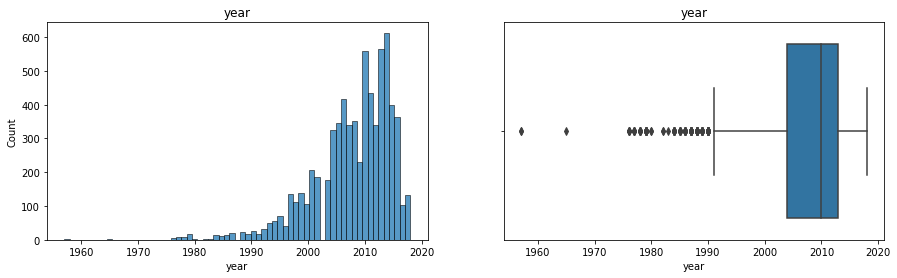

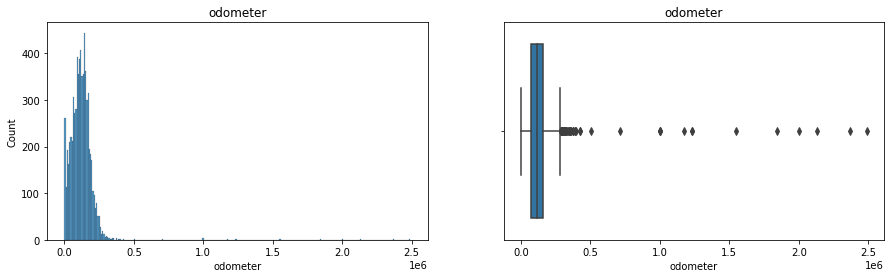

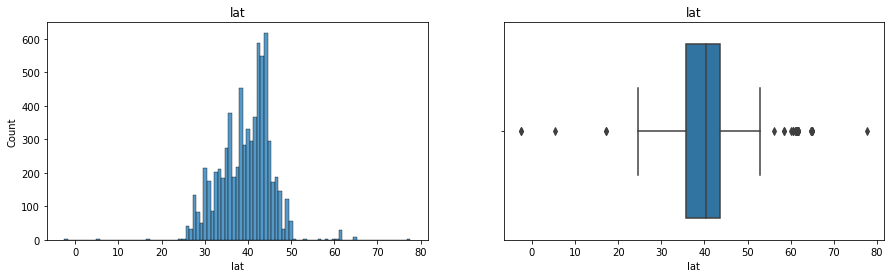

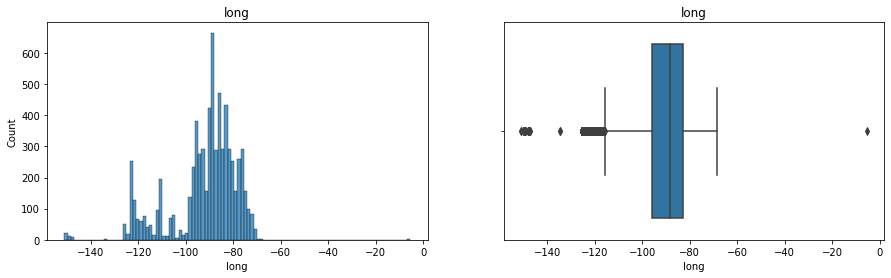

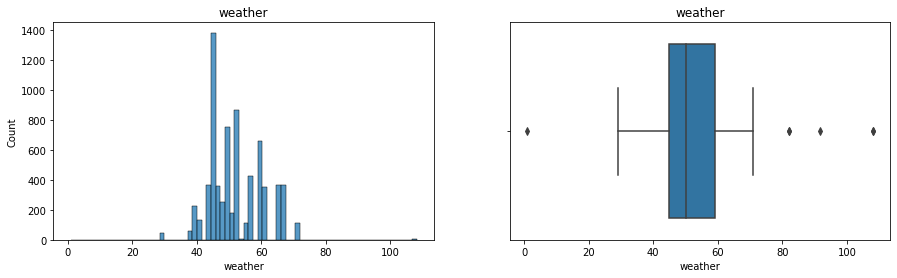

In [42]:
#построим гистограмму и boxplot для каждого числового признака
for _ in x_outliers.columns:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
    histplot = sns.histplot(data=x_outliers, x=_, ax=axes[0]);
    histplot.set_title(_);
    boxplot = sns.boxplot(data=x_outliers, x=_, ax=axes[1]);
    boxplot.set_title(_);

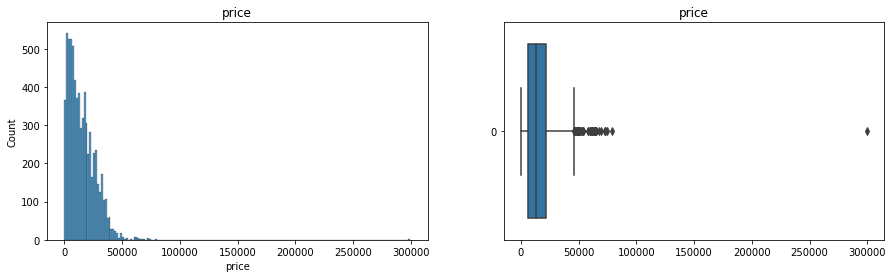

In [43]:
#построим гистограмму и boxplot для целевого признака
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=y_outliers, ax=axes[0]);
histplot.set_title('price');
boxplot = sns.boxplot(data=y_outliers, orient='h', ax=axes[1], );
boxplot.set_title('price');

In [44]:
X_train, X_test, y_train, y_test = train_test_split(x_outliers, y_outliers, test_size=0.3, random_state=40)

model = LinearRegression()
model.fit(X_train, y_train)
y_predicted = model.predict(X_test)
 
mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)


MAE: 4869.498


Настало время обработки выбросов.

1
Первый алгоритм, который мы применим, — **Isolation Forest**, или iForest. Это алгоритм обнаружения аномалий на основе дерева.


In [45]:
from  sklearn.ensemble import IsolationForest
 
# ищем выбросы в обучающей выборке
iso = IsolationForest(contamination=0.1)
y_predicted = iso.fit_predict(X_train)
 
# выберем все строки, которые не являются выбросами
mask = y_predicted != -1
X_train, y_train = X_train[mask], y_train[mask]
 
print(X_train.shape, y_train.shape)
 
model = LinearRegression()
model.fit(X_train, y_train)
 
y_predicted = model.predict(X_test)
mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


(4426, 5) (4426,)
MAE: 4613.107


2
Следующий метод — **Local Outlier Factor**, или LOF. Это метод, который пытается использовать идею ближайших соседей для обнаружения выбросов.

In [46]:
from sklearn.neighbors import LocalOutlierFactor

X_train, X_test, y_train, y_test = train_test_split(x_outliers, y_outliers, test_size=0.3, random_state=40)
 
lof = LocalOutlierFactor()
y_predicted = lof.fit_predict(X_train)

mask = y_predicted != -1
X_train, y_train = X_train[mask], y_train[mask]
 
print(X_train.shape, y_train.shape)
 
model = LinearRegression()
model.fit(X_train, y_train)
 
y_predicted = model.predict(X_test)
mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)

(4526, 5) (4526,)
MAE: 4605.449


3
Напоследок рассмотрим Minimum Covariance Determinant, или MCD.

Если входные переменные имеют гауссово распределение, то для обнаружения выбросов можно использовать простые статистические методы.

Например, если набор данных имеет две входные переменные и обе они являются гауссовыми, то пространство признаков образует многомерную гауссовскую зависимость, и знание этого распределения можно использовать для определения значений, далёких от распределения.

Этот подход можно обобщить, определив гиперсферу (эллипсоид), которая покрывает нормальные данные, а данные, выходящие за пределы этой формы, считаются выбросами. Эффективная реализация этого метода для многомерных данных известна как детерминант минимальной ковариации (MCD).

Библиотека scikit-learn предоставляет доступ к этому методу через класс EllipticEnvelope.

In [47]:
from sklearn.covariance import EllipticEnvelope

X_train, X_test, y_train, y_test = train_test_split(x_outliers, y_outliers, test_size=0.3, random_state=40)
 
ee = EllipticEnvelope(contamination=0.01)
y_predicted = ee.fit_predict(X_train)

mask = y_predicted != -1
X_train, y_train = X_train[mask], y_train[mask]
 
print(X_train.shape, y_train.shape)
model = LinearRegression()
model.fit(X_train, y_train)
 
y_predicted = model.predict(X_test)
mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)

(4860, 5) (4860,)
MAE: 4592.053


Мы видим, что оптимальный результат достигается с помощью алгоритма MCD.
Применим этот метод для всего датасета.


In [48]:
y_predicted = ee.fit_predict(x_outliers)
mask = y_predicted != -1
x, y = x[mask], y[mask]
x_outliers, y_outliers = x_outliers[mask], y_outliers[mask]

Визуализируем результаты чистки от выбросов

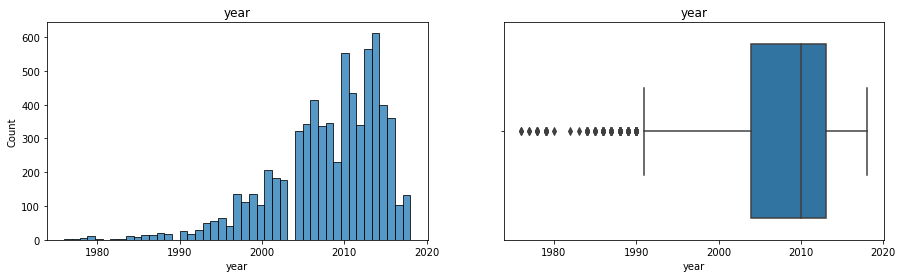

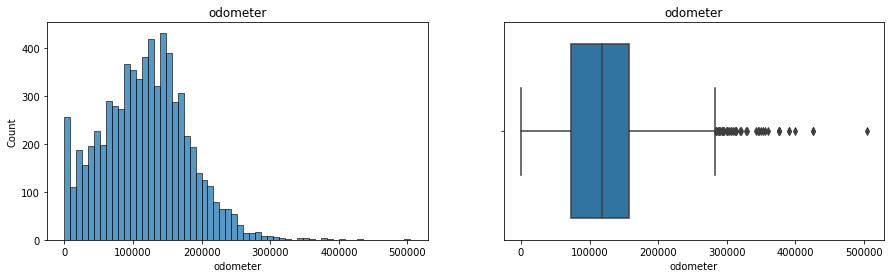

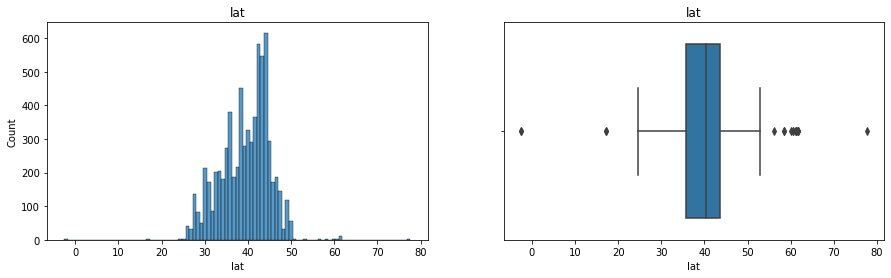

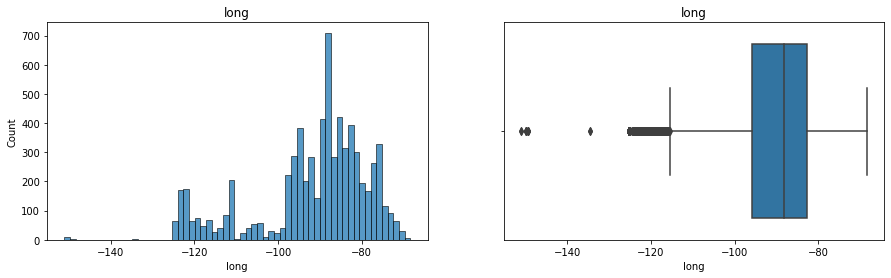

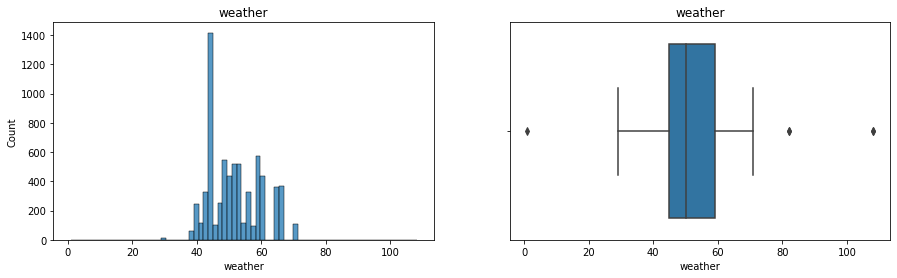

In [49]:
#построим гистограмму и boxplot для каждого числового признака
for _ in x_outliers.columns:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
    histplot = sns.histplot(data=x_outliers, x=_, ax=axes[0]);
    histplot.set_title(_);
    boxplot = sns.boxplot(data=x_outliers, x=_, ax=axes[1]);
    boxplot.set_title(_);

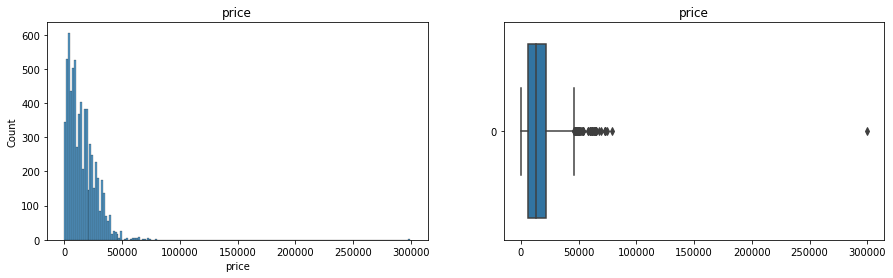

In [50]:
#построим гистограмму и boxplot для целевого признака
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=y_outliers, ax=axes[0]);
histplot.set_title('price');
boxplot = sns.boxplot(data=y_outliers, orient='h', ax=axes[1], );
boxplot.set_title('price');

Есть изменения, но некоторые аномалии всё же удалить не удалось. В частности, в признаке weather среднегодовая температура около 1 Фаренгейта(-17 С).
Посмотрим подробнее на это место.

In [51]:
mask1 = x['weather'] < 10
x[mask1]

,year,condition,odometer,lat,long,weather,cylinders_3,cylinders_4,cylinders_5,cylinders_6,...,transmission_automatic,transmission_manual,transmission_other,drive_4wd,drive_fwd,drive_rwd,size_compact,size_full-size,size_mid-size,size_sub-compact
5653,1996,2,241554,77.617682,-100.174193,0.987345,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


Судя по координатам это север Канады. Так что вполне возможно.

Ещё я бы проверил максимальное значение целевой переменной

In [52]:
y.describe()

count      6946.000000
mean      15202.989346
std       11776.381170
min           1.000000
25%        5996.000000
50%       12900.000000
75%       21995.000000
max      299500.000000
Name: price, dtype: float64

In [53]:
mask2 = data['price'] > 200000

In [54]:
data[mask2]

,price,year,condition,cylinders,odometer,title_status,transmission,drive,size,lat,long,weather
3605,299500,2002,3,8,177000,clean,automatic,NaN,NaN,25.904769,-97.45952,67.0


Возможно коллекционная модель. Но маловероятно. 2002 год, средней кондиции Такие автомобили продаются на специализированных площадках, а мне могут попортить качество модели. Поэтому я решаю удалить это наблюдение.

In [55]:
x.loc[3605]

year                        2002.000000
condition                      3.000000
odometer                  177000.000000
lat                           25.904769
long                         -97.459520
weather                       67.000000
cylinders_3                    0.000000
cylinders_4                    0.000000
cylinders_5                    0.000000
cylinders_6                    0.000000
cylinders_8                    1.000000
cylinders_10                   0.000000
title_status_clean             1.000000
title_status_lien              0.000000
title_status_missing           0.000000
title_status_rebuilt           0.000000
title_status_salvage           0.000000
transmission_automatic         1.000000
transmission_manual            0.000000
transmission_other             0.000000
drive_4wd                      0.000000
drive_fwd                      0.000000
drive_rwd                      1.000000
size_compact                   0.000000
size_full-size                 1.000000


In [56]:
y_outliers.loc[3605]

299500

In [57]:
#удаляем наблюдение из обоих датасетов
x = x.drop(index=[3605])
y = y.drop(index=[3605])

В результате у нас появилась выборка без выбросов и синхронизированный с ней "учитель". 

#Преобразование признаков: Масштабирование

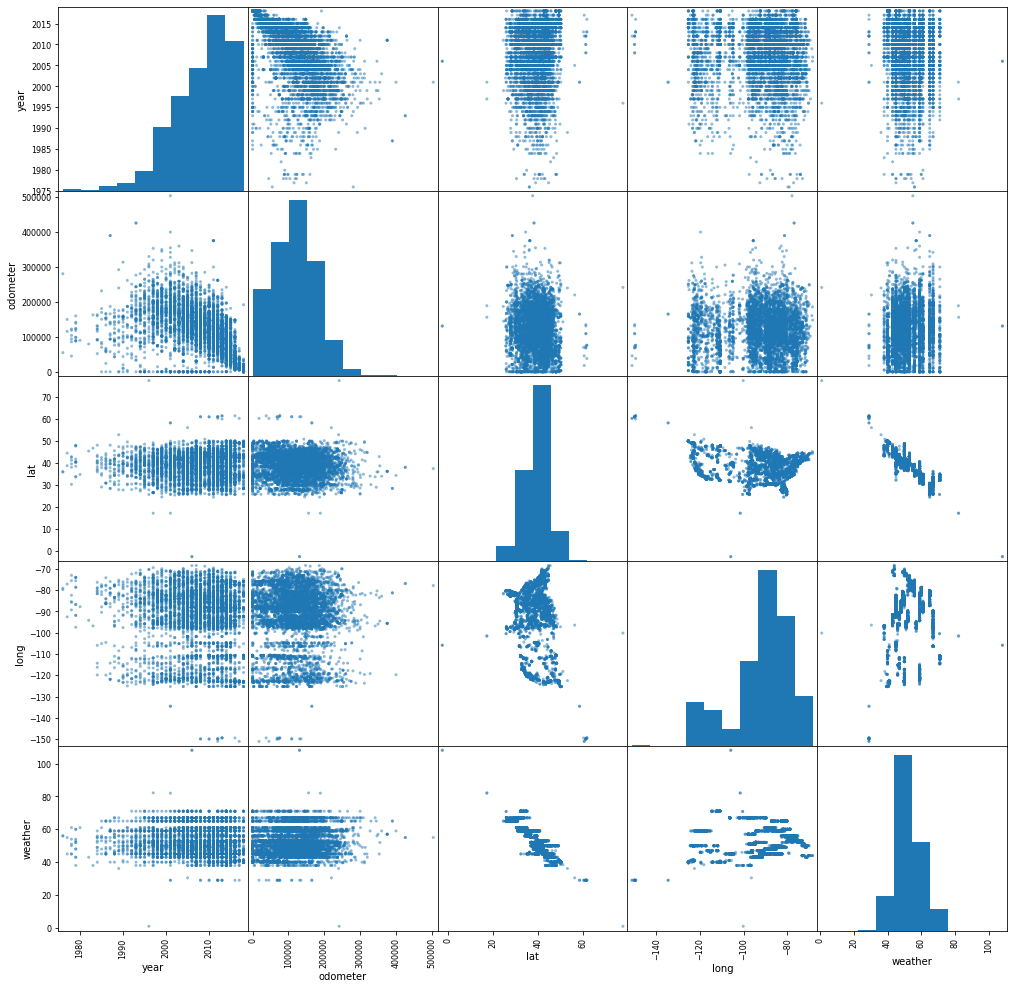

In [58]:
pd.plotting.scatter_matrix(x[['year','odometer' ,'lat', 'long','weather']], alpha=0.5, figsize=(17,17));

Нормально распределённых признаков нет. Более-менее распределение похоже на нормальное у признака weather и lat. Проверим с помощью  теста Шапиро-Уилка

In [59]:
!pip install scipy
!pip install statsmodels
#Тест Шапиро-Уилка на нормальность
from scipy.stats import shapiro

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [60]:
#Обозначим статистические гипотезы
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'

In [61]:
#Установим уровень значимости
alpha = 0.05

In [62]:
_, p = shapiro(x['weather'])
print('p=%.3f' % p)

# Интерпретация 

if p > alpha:
	print(H0)
else:
	print(Ha)

p=0.000
Данные не распределены нормально (мы отвергаем H0)


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [63]:
_, p = shapiro(x['lat'])
print('p=%.3f' % p)

# Интерпретация 

if p > alpha:
	print(H0)
else:
	print(Ha)

p=0.000
Данные не распределены нормально (мы отвергаем H0)


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Данные распределены ненормально. Будем нормализовать и стандартизировать

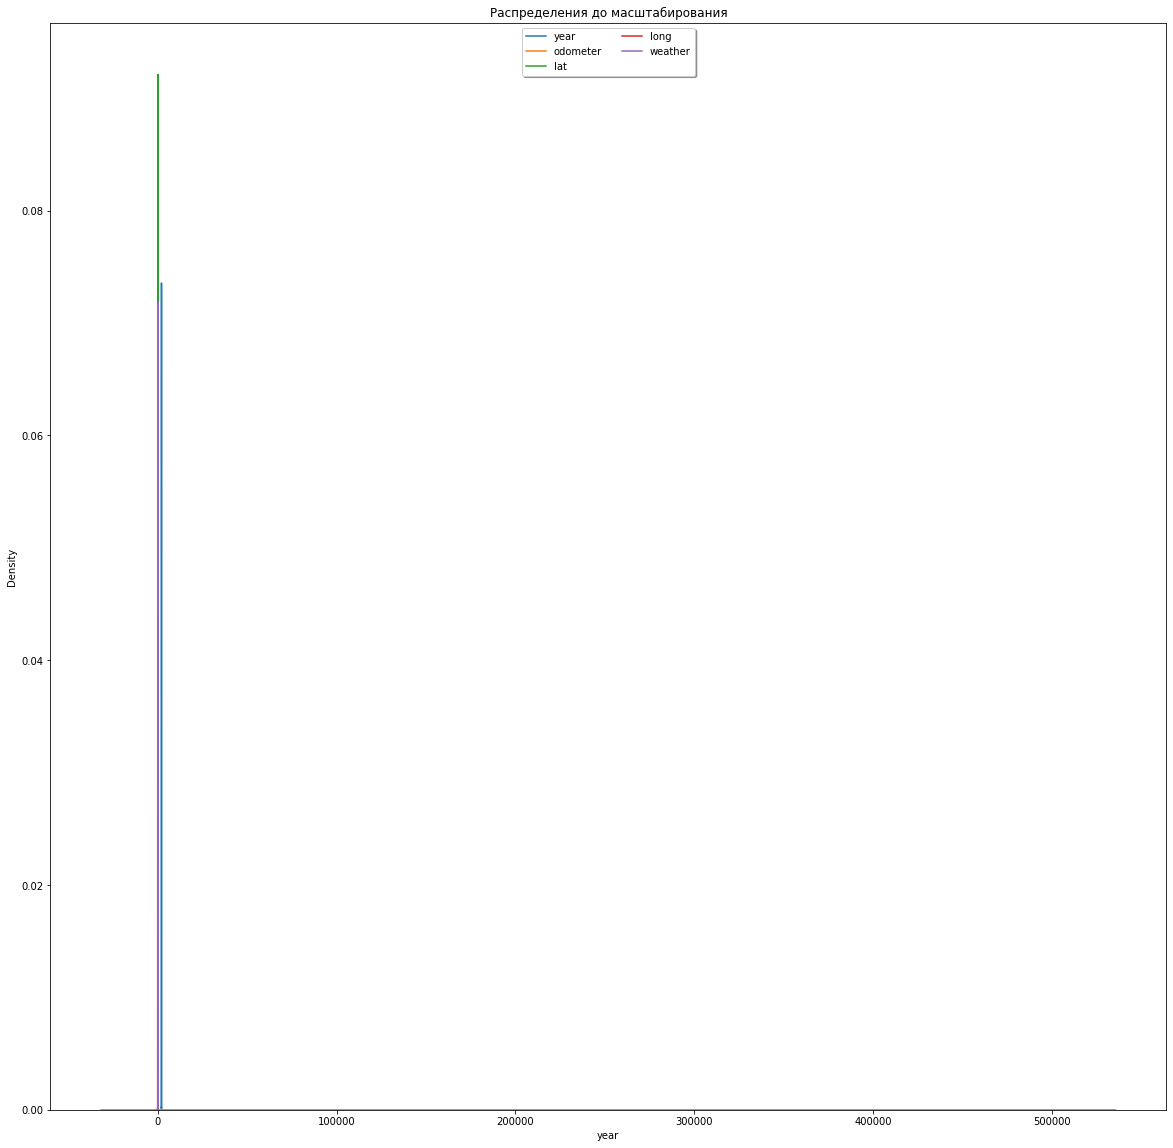

In [64]:
#Для начала визуализируем то, что есть на данный момент
fig, (ax1) = plt.subplots(ncols=1, figsize=(20,20))
ax1.set_title('Распределения до масштабирования')

sns.kdeplot(x['year'], ax=ax1, label ='year')
sns.kdeplot(x['odometer'], ax=ax1, label ='odometer')
sns.kdeplot(x['lat'], ax=ax1, label ='lat')
sns.kdeplot(x['long'], ax=ax1, label ='long')
sns.kdeplot(x['weather'], ax=ax1, label ='weather')

plt.legend(loc='upper center', shadow=True, ncol=2)

Используем трансформацию признаков в более нормальное распределение методом POWER TRANSFORMER SCALER.
Также этот метод по умолчанию и стандартизирует признаки.
Т.к. в наших данных возможно есть нулевые и точно отрицательные значения обрабатываемых переменных, используем Преобразование Йео-Джонсона

In [65]:
from sklearn.preprocessing import PowerTransformer
yeo_john = PowerTransformer(method = 'yeo-johnson')
 
data_yeo_john = yeo_john.fit_transform(x[['year','odometer' ,'lat', 'long','weather']].values)
data_yeo_john = pd.DataFrame(data_yeo_john, columns = ['tr_year','tr_odometer' ,'tr_lat', 'tr_long','tr_weather'])

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


In [66]:
data_yeo_john.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6945 entries, 0 to 6944
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   tr_year      6945 non-null   float64
 1   tr_odometer  6945 non-null   float64
 2   tr_lat       6945 non-null   float64
 3   tr_long      6945 non-null   float64
 4   tr_weather   6945 non-null   float64
dtypes: float64(5)
memory usage: 271.4 KB


In [67]:
data_yeo_john.head()

,tr_year,tr_odometer,tr_lat,tr_long,tr_weather
0,1.318350,-1.174098,-0.581752,0.652299,0.892914
1,0.078301,-0.196671,0.137405,1.786769,0.050027
2,-0.978784,1.251967,0.517346,0.598754,-0.862338
3,-1.251008,0.845205,0.192545,0.667866,-0.331589
4,0.243580,0.788605,1.879415,-1.835066,-1.433749


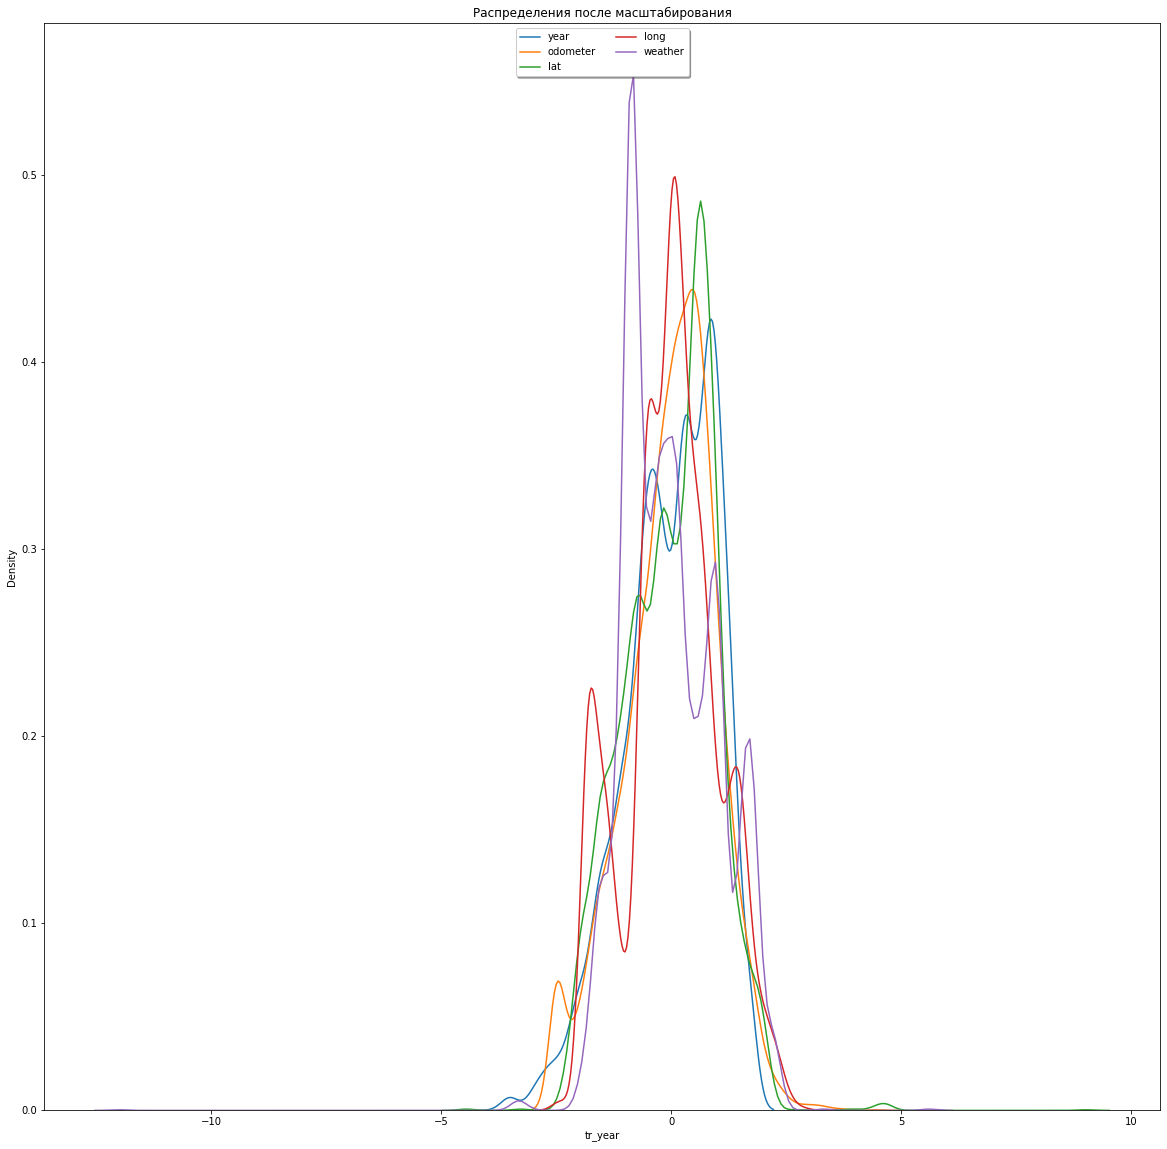

In [68]:
#Теперь визуализируем результаты нормализации и стандартизации
fig, (ax1) = plt.subplots(ncols=1, figsize=(20,20))
ax1.set_title('Распределения после масштабирования')

sns.kdeplot(data_yeo_john['tr_year'], ax=ax1, label ='year')
sns.kdeplot(data_yeo_john['tr_odometer'], ax=ax1, label ='odometer')
sns.kdeplot(data_yeo_john['tr_lat'], ax=ax1, label ='lat')
sns.kdeplot(data_yeo_john['tr_long'], ax=ax1, label ='long')
sns.kdeplot(data_yeo_john['tr_weather'], ax=ax1, label ='weather')

plt.legend(loc='upper center', shadow=True, ncol=2)

Теперь объединим таблицы

In [69]:
x.tail()

,year,condition,odometer,lat,long,weather,cylinders_3,cylinders_4,cylinders_5,cylinders_6,...,transmission_automatic,transmission_manual,transmission_other,drive_4wd,drive_fwd,drive_rwd,size_compact,size_full-size,size_mid-size,size_sub-compact
7012,2015,3,23500,32.680700,-117.169800,59.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
7013,2005,2,0,38.213303,-85.785762,50.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
7014,2006,3,161514,37.609783,-120.995406,59.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
7015,2011,2,164000,43.140600,-93.385000,47.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
7016,2010,2,104000,37.987200,-84.178900,50.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [70]:
#сбросим индексы у основного датафрейма
x.reset_index(inplace=True)

In [71]:
x.tail()

,index,year,condition,odometer,lat,long,weather,cylinders_3,cylinders_4,cylinders_5,...,transmission_automatic,transmission_manual,transmission_other,drive_4wd,drive_fwd,drive_rwd,size_compact,size_full-size,size_mid-size,size_sub-compact
6940,7012,2015,3,23500,32.680700,-117.169800,59.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
6941,7013,2005,2,0,38.213303,-85.785762,50.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
6942,7014,2006,3,161514,37.609783,-120.995406,59.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
6943,7015,2011,2,164000,43.140600,-93.385000,47.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
6944,7016,2010,2,104000,37.987200,-84.178900,50.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [72]:
#Теперь объединим по индексам 
x = x.join(data_yeo_john)


In [73]:
#удалим преобразованные столбцы
x = x.drop(['index','year','odometer' ,'lat', 'long','weather'], axis=1)

In [74]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6945 entries, 0 to 6944
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   condition               6945 non-null   int64  
 1   cylinders_3             6945 non-null   float64
 2   cylinders_4             6945 non-null   float64
 3   cylinders_5             6945 non-null   float64
 4   cylinders_6             6945 non-null   float64
 5   cylinders_8             6945 non-null   float64
 6   cylinders_10            6945 non-null   float64
 7   title_status_clean      6945 non-null   float64
 8   title_status_lien       6945 non-null   float64
 9   title_status_missing    6945 non-null   float64
 10  title_status_rebuilt    6945 non-null   float64
 11  title_status_salvage    6945 non-null   float64
 12  transmission_automatic  6945 non-null   float64
 13  transmission_manual     6945 non-null   float64
 14  transmission_other      6945 non-null   

Теперь датафрейм готов к отбору признаков

#Отбор признаков

Разделим выборку на тренировочную и тестовую части.

In [75]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x, y, test_size=0.2, random_state=42)

In [76]:
x_train1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5556 entries, 44 to 860
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   condition               5556 non-null   int64  
 1   cylinders_3             5556 non-null   float64
 2   cylinders_4             5556 non-null   float64
 3   cylinders_5             5556 non-null   float64
 4   cylinders_6             5556 non-null   float64
 5   cylinders_8             5556 non-null   float64
 6   cylinders_10            5556 non-null   float64
 7   title_status_clean      5556 non-null   float64
 8   title_status_lien       5556 non-null   float64
 9   title_status_missing    5556 non-null   float64
 10  title_status_rebuilt    5556 non-null   float64
 11  title_status_salvage    5556 non-null   float64
 12  transmission_automatic  5556 non-null   float64
 13  transmission_manual     5556 non-null   float64
 14  transmission_other      5556 non-null   

In [77]:
y_train1.shape

(5556,)

Выделим три столбца-признака для обучения с помощью метода RFE.

In [78]:
from sklearn.feature_selection import RFE
 
estimator = LinearRegression()
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(x_train1, y_train1)
 
selector.get_feature_names_out()

array(['title_status_clean', 'title_status_lien', 'title_status_salvage'],
      dtype=object)

In [83]:
#подготовим список признаков для построения модели логистической регрессии
list_RFE = list(selector.get_feature_names_out())

Также узнаем, как RFE проранжировал все доступные признаки:

In [79]:
x_train1.columns

Index(['condition', 'cylinders_3', 'cylinders_4', 'cylinders_5', 'cylinders_6',
       'cylinders_8', 'cylinders_10', 'title_status_clean',
       'title_status_lien', 'title_status_missing', 'title_status_rebuilt',
       'title_status_salvage', 'transmission_automatic', 'transmission_manual',
       'transmission_other', 'drive_4wd', 'drive_fwd', 'drive_rwd',
       'size_compact', 'size_full-size', 'size_mid-size', 'size_sub-compact',
       'tr_year', 'tr_odometer', 'tr_lat', 'tr_long', 'tr_weather'],
      dtype='object')

In [80]:
selector.ranking_

array([22, 21, 13, 11, 14, 12, 10,  1,  1,  3,  2,  1,  4,  6,  5,  7,  9,
        8, 18, 16, 15, 17, 19, 20, 25, 23, 24])

Обучим модель логистической регрессии на полученных признаках.

In [86]:
model = LinearRegression()
model.fit(x_train1[list_RFE], y_train1)
 
y_predicted = model.predict(x_test1[list_RFE])
mae = mean_absolute_error(y_test1, y_predicted)
print('MAE: %.3f' % mae)

MAE: 9039.063


Выделим три столбца-признака для обучения с помощью метода: выбор k лучших переменных SelectKBest

In [87]:
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(f_regression, k=3)
selector.fit(x_train1, y_train1)
 
selector.get_feature_names_out()

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


array(['condition', 'tr_year', 'tr_odometer'], dtype=object)

In [89]:
#подготовим список признаков для построения модели логистической регрессии
list_SelectKBest = list(selector.get_feature_names_out())

In [90]:
model = LinearRegression()
model.fit(x_train1[list_SelectKBest], y_train1)
 
y_predicted = model.predict(x_test1[list_SelectKBest])
mae = mean_absolute_error(y_test1, y_predicted)
print('MAE: %.3f' % mae)

MAE: 4128.045


Производим сравнение выбранных метрик. Наилучший результат на тестовой выборке показал метод отбора признаков SelectKBest